# 0: Imports

In [1]:
# General imports
import pandas as pd

# Data cleaning pipeline imports
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# 1. Data Loading

In [3]:
import pandas as pd

#traffic = pd.read_csv('/content/sample_data/sampled_traffic.csv')
#traffic = pd.read_csv('/content/sample_data/full_traffic.csv')

#traffic = pd.read_csv('sampled_traffic.csv')
traffic = pd.read_csv('full_traffic.csv')

In [4]:
traffic.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [5]:
len(traffic)

7728394

In [6]:
traffic.isna().sum()

ID                             0
Source                         0
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  3402762
End_Lng                  3402762
Distance(mi)                   0
Description                    5
Street                     10869
City                         253
County                         0
State                          0
Zipcode                     1915
Country                        0
Timezone                    7808
Airport_Code               22635
Weather_Timestamp         120228
Temperature(F)            163853
Wind_Chill(F)            1999019
Humidity(%)               174144
Pressure(in)              140679
Visibility(mi)            177098
Wind_Direction            175206
Wind_Speed(mph)           571233
Precipitation(in)        2203586
Weather_Condition         173459
Amenity                        0
Bump      

# 2. Data Cleaning and Munging

In [7]:
traffic['Weather_Timestamp'].head()

0    2016-02-08 05:58:00
1    2016-02-08 05:51:00
2    2016-02-08 06:56:00
3    2016-02-08 07:38:00
4    2016-02-08 07:53:00
Name: Weather_Timestamp, dtype: object

In [8]:
traffic['Weather_Condition'].head()

0       Light Rain
1       Light Rain
2         Overcast
3    Mostly Cloudy
4    Mostly Cloudy
Name: Weather_Condition, dtype: object

#### Missing Value Handling Plan:
- Because `End_Lat` and `End_Lng` each have 3.4M+ missing values (44.02935% of the full dataset), we chose to drop these columns to focus just on the location of the accident.
- `Wind_Speed` and `Precipitation` also have a significant number of missing values. These columns cannot be simply or reliably imputed because of their dependence on time, location, and data collection agencies. However, we did not want to drop these columns because of their possible significance to traffic accident severity. We decided to investigate their relationship with accident severity level using statistical methods (box-plots and ANOVA).
- `Street`was dropped from the dataset. Given the granularity of the Lat/Lng coordinates, we did not think we needed this column for our analysis. We figured it could be added back somehow at the end of the analysis, perhaps by creating a unique ID code for each row given Lat/Lng to easily do this but we did not explore this step for this analysis.
- `City`, `Zipcode`, `Timezone`, `Airport_Code` can be easily imputed using python packages given the Lat/Lng coordinates. However, we do not see the need to keep all of these variables. We chose to retain `City` and `Zipcode` and impute their missing values in case we wanted to examine traffic accident severity with these columns.
- `Weather_Timestamp`, `Temperature`, `Humidity`, `Pressure`, `Visibility`, `Wind_Direction` each do not have excessive missingness. Of these variables, `Visibility` has the most missing values (177,098 missing, 2.29150% of total rows), so we decided to drop rows with missing values in these columns.
- `Sunrise_Sunset`, `Civil_Twilight`, `Nautical_Twilight`, `Astronomical_Twilight` may have some impact on traffic activity. These variables also likely have some impact on the drowsiness of drivers. However, we chose to drop these columns because they are time columns and to our knowledge, not simply ingested by machine learning algorithms. In the future, we could impute these values using the python `astral` package and figure out how to use this data in an analysis but we chose to focus our analysis on other variables.
- `Weather_Condition` is an important variable with 173,459 missing values (2.2444% of the full dataset). We considered imputing these values with a nearest-neighbors approach after grouping by city, but were unsure of how this approach would affect the truth in our dataset. We chose to impute mode by city into 'Weather_Condition' instead, understanding that we may be amplifying the effect of certain weather conditions.
- `Wind_Speed` has 36,987 missing values. This is not a significant portion of the dataset. We chose to drop na rows from this column.

In [9]:
traffic.columns

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
import time
import numpy as np

def get_city(lat, lon):
    if pd.isna(lat) or pd.isna(lon):
        return None
    try:
        lat = float(lat)
        lon = float(lon)
    except ValueError:
        return None
    if not (-90 <= lat <= 90) or not (-180 <= lon <= 180):
        return None
    geolocator = Nominatim(user_agent="my_agent")
    try:
        location = geolocator.reverse(f"{lat}, {lon}")
        if location and 'address' in location.raw:
            address = location.raw['address']
            return address.get('city') or address.get('town') or address.get('village')
    except (GeocoderTimedOut, GeocoderServiceError, ValueError):
        time.sleep(1)  # Wait for 1 second before retrying
    return None

def fill_missing_city(df):
    mask = df['City'].isna()
    missing_cities = df[mask]
    for idx, row in missing_cities.iterrows():
        city = get_city(row['Start_Lat'], row['Start_Lng'])
        if city:
            df.at[idx, 'City'] = city
    return df

columns_to_drop = ['End_Lat', 'End_Lng', 'Street', 'Timezone', 'Airport_Code', 
                   'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 
                   'Astronomical_Twilight', 'Wind_Chill(F)', 'Precipitation(in)']

def preprocess_data(X):
    X = X.drop(columns=columns_to_drop)
    X = fill_missing_city(X)
    X = X.dropna(subset=['City', 'Description'])
    X['Weather_Condition'] = X.groupby('City')['Weather_Condition'].transform(
        lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'Unknown')
    )
    columns_to_check_na = ['Weather_Timestamp', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)']
    X = X.dropna(subset=columns_to_check_na)
    return X

pipeline = Pipeline([
    ('preprocess', FunctionTransformer(preprocess_data, validate=False))
])

result = pipeline.fit_transform(traffic)
result_df = pd.DataFrame(result, columns=[col for col in traffic.columns if col not in columns_to_drop])
print("Shape before processing:", traffic.shape)
print("Shape after processing:", result_df.shape)

Shape before processing: (7728394, 46)
Shape after processing: (7095549, 35)


In [11]:
result_df.isna().sum()

ID                   0
Source               0
Severity             0
Start_Time           0
End_Time             0
Start_Lat            0
Start_Lng            0
Distance(mi)         0
Description          0
City                 0
County               0
State                0
Zipcode              0
Country              0
Weather_Timestamp    0
Temperature(F)       0
Humidity(%)          0
Pressure(in)         0
Visibility(mi)       0
Wind_Direction       0
Wind_Speed(mph)      0
Weather_Condition    0
Amenity              0
Bump                 0
Crossing             0
Give_Way             0
Junction             0
No_Exit              0
Railway              0
Roundabout           0
Station              0
Stop                 0
Traffic_Calming      0
Traffic_Signal       0
Turning_Loop         0
dtype: int64

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming your dataframe is named results_df and the target variable is 'severity'

# Separate features and target
X = result_df.drop('Severity', axis=1)
y = result_df['Severity']

# Identify numerical and categorical columns
numerical_columns = X.select_dtypes(include=[np.number]).columns
categorical_columns = X.select_dtypes(exclude=[np.number]).columns

print("Numerical columns:", numerical_columns.tolist())
print("Categorical columns:", categorical_columns.tolist())

# Perform stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Combine features and target for each split
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Shuffle the rows of each dataframe
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the full datasets
train_df.to_csv('train_data_full.csv', index=False)
test_df.to_csv('test_data_full.csv', index=False)

# Save numerical and categorical datasets separately
train_df[numerical_columns].to_csv('train_data_numerical.csv', index=False)
test_df[numerical_columns].to_csv('test_data_numerical.csv', index=False)
train_df[categorical_columns].to_csv('train_data_categorical.csv', index=False)
test_df[categorical_columns].to_csv('test_data_categorical.csv', index=False)

# Save target variable separately
train_df['Severity'].to_csv('train_target.csv', index=False)
test_df['Severity'].to_csv('test_target.csv', index=False)

print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
print("Datasets have been saved as CSV files")

Numerical columns: ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']
Categorical columns: ['ID', 'Source', 'Start_Time', 'End_Time', 'Description', 'City', 'County', 'State', 'Zipcode', 'Country', 'Weather_Timestamp', 'Wind_Direction', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']
Train set shape: (5676439, 35)
Test set shape: (1419110, 35)
Datasets have been saved as CSV files


In [ ]:
y = result_df['Severity']


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
train_df = pd.read_csv('train_data_full.csv')
test_df = pd.read_csv('test_data_full.csv')

# Separate features and target
X_train = train_df.drop('Severity', axis=1)
y_train = train_df['Severity']
X_test = test_df.drop('Severity', axis=1)
y_test = test_df['Severity']

# Identify numerical and categorical columns
numerical_columns = X_train.select_dtypes(include=[np.number]).columns
categorical_columns = X_train.select_dtypes(exclude=[np.number]).columns

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

# Create a pipeline with preprocessor and random forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit the pipeline
rf_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = rf_pipeline.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature importance
feature_importance = rf_pipeline.named_steps['classifier'].feature_importances_
feature_names = (numerical_columns.tolist() + 
                 rf_pipeline.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names(categorical_columns).tolist())

# Sort feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# Print the feature ranking
print("\nFeature importance ranking:")
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], feature_importance[indices[f]]))

# Plot feature importances
plt.figure(figsize=(12,8))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feature_importance[indices])
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


-------------------- Full Dataset EDA --------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095549 entries, 0 to 7095548
Data columns (total 35 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ID                 object 
 1   Source             object 
 2   Start_Time         object 
 3   End_Time           object 
 4   Start_Lat          float64
 5   Start_Lng          float64
 6   Distance(mi)       float64
 7   Description        object 
 8   City               object 
 9   County             object 
 10  State              object 
 11  Zipcode            object 
 12  Country            object 
 13  Weather_Timestamp  object 
 14  Temperature(F)     float64
 15  Humidity(%)        float64
 16  Pressure(in)       float64
 17  Visibility(mi)     float64
 18  Wind_Direction     object 
 19  Wind_Speed(mph)    float64
 20  Weather_Condition  object 
 21  Amenity            bool   
 22  Bump               bool   
 23  Crossing           bo

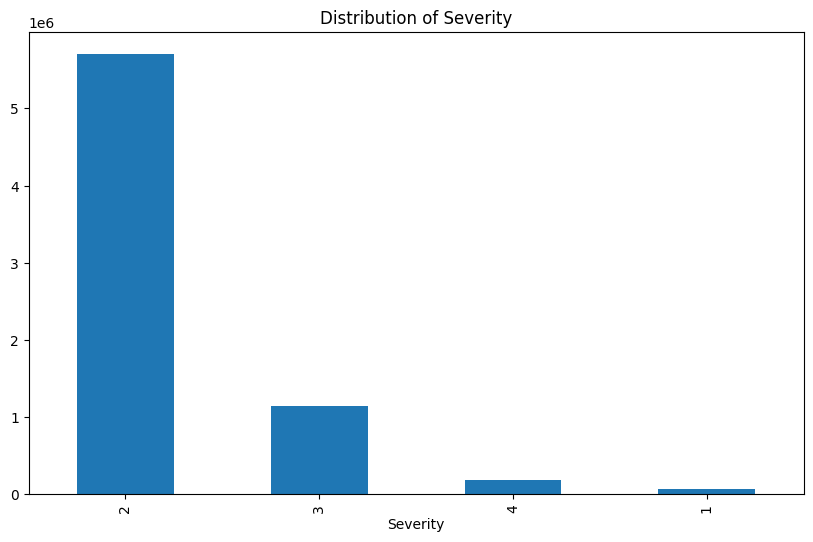

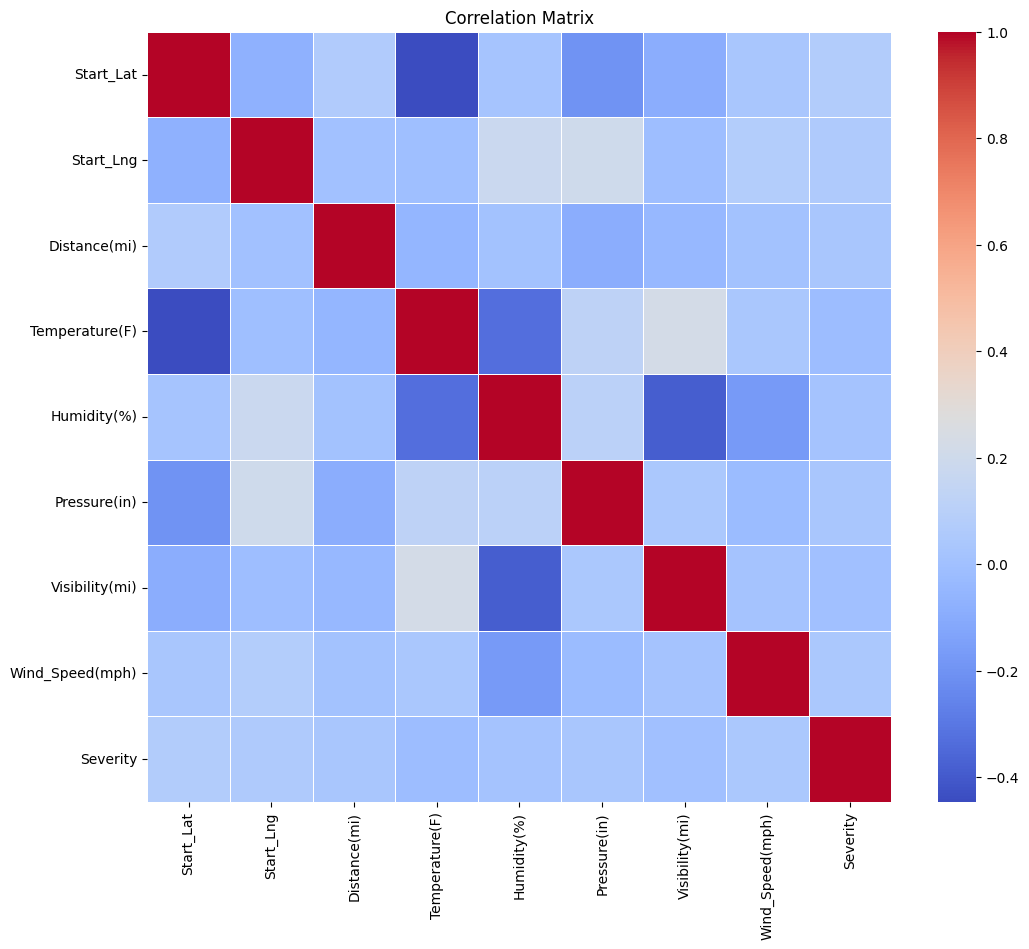

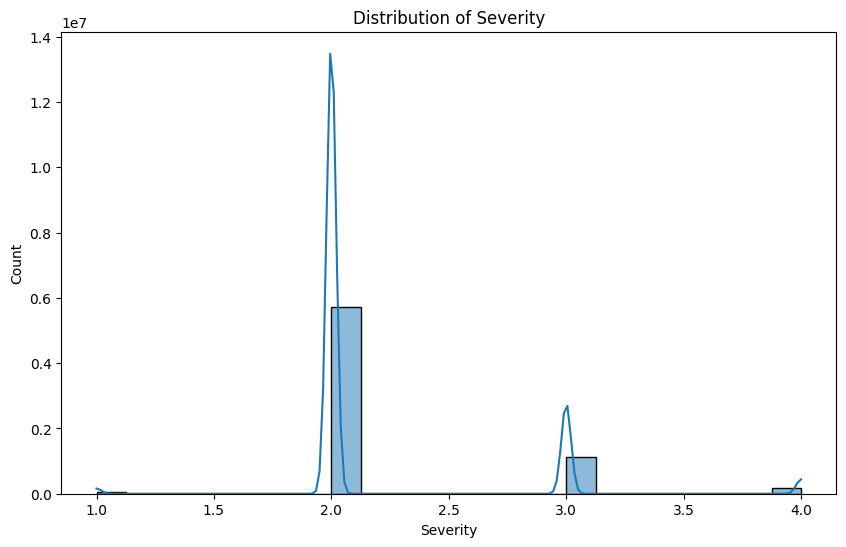

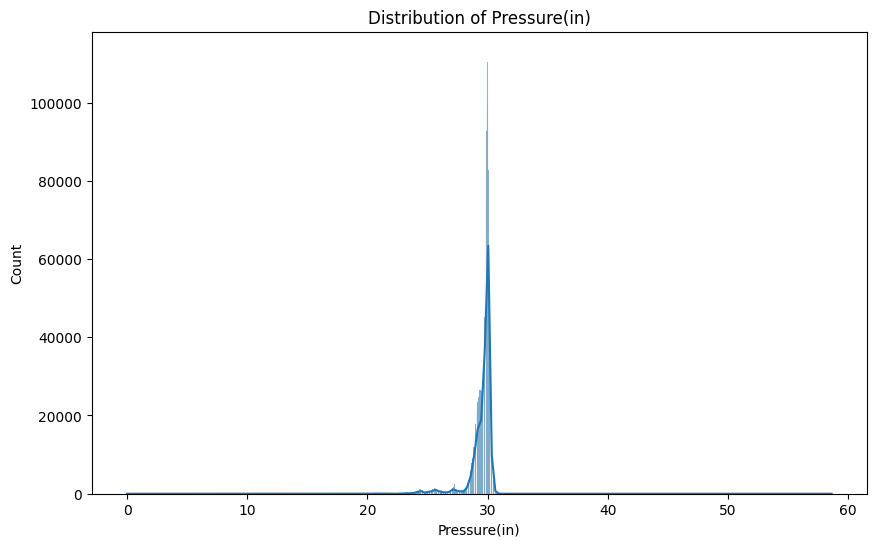

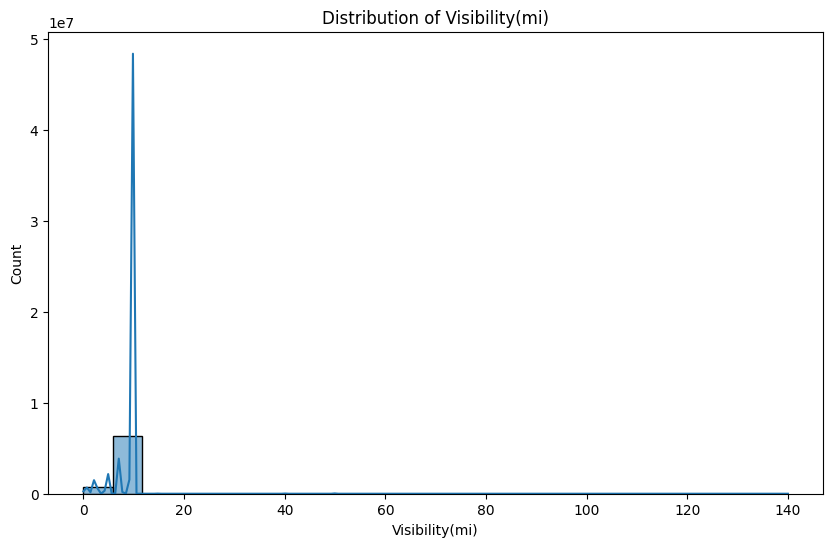

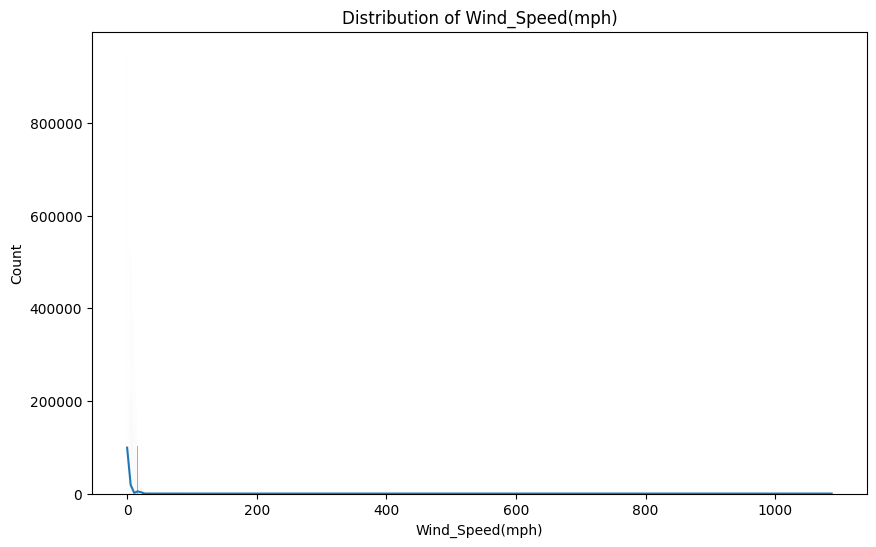

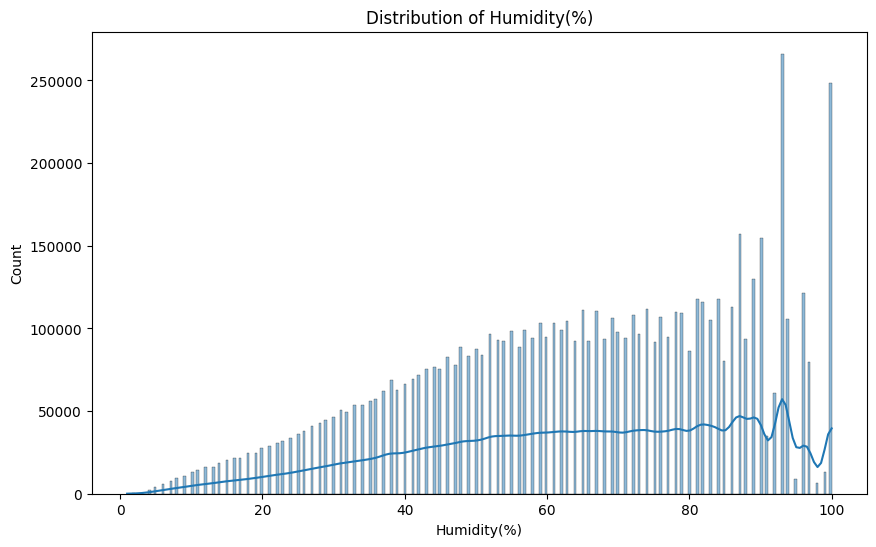

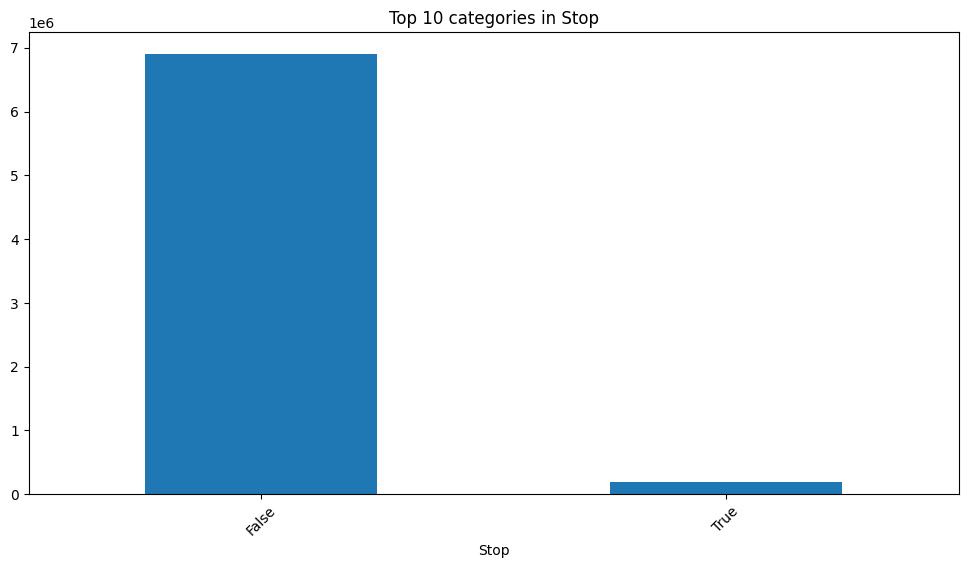

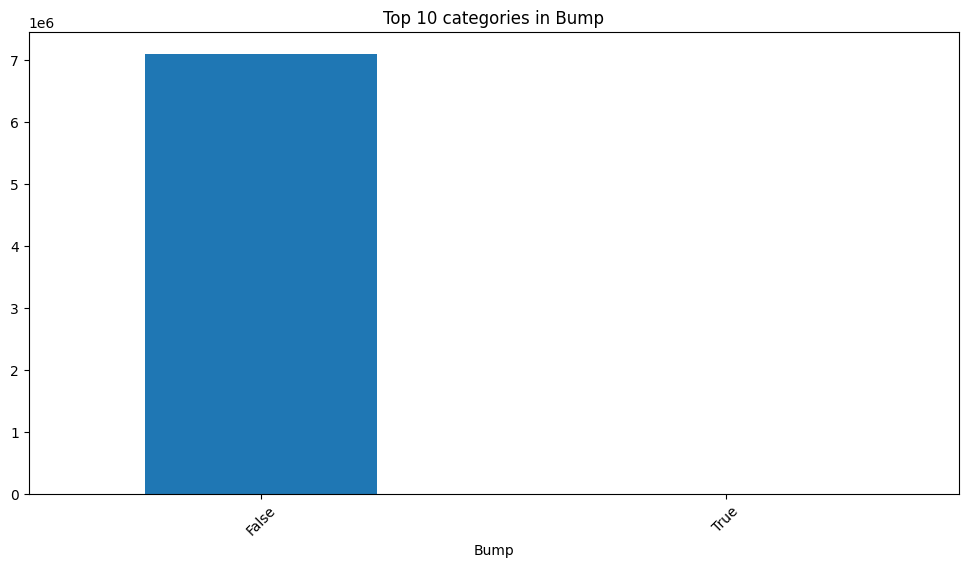

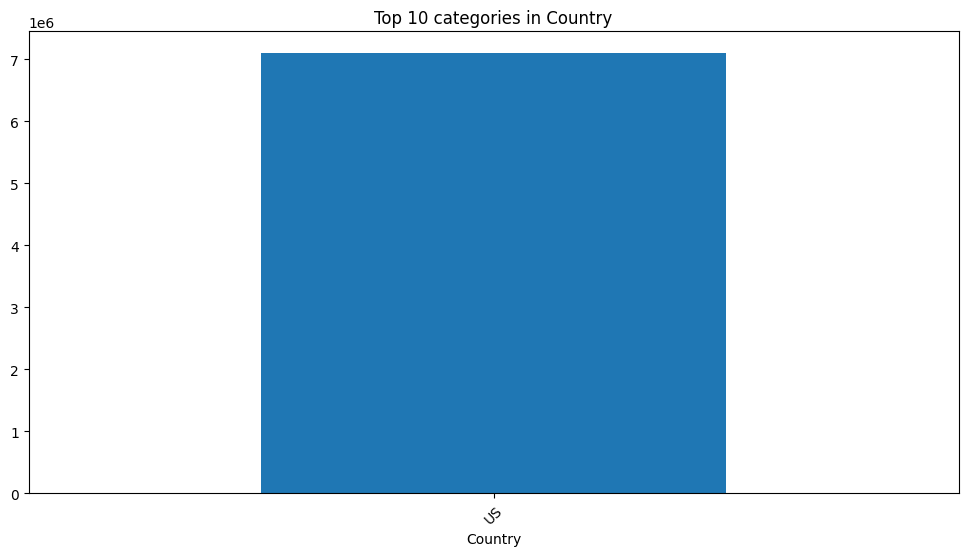

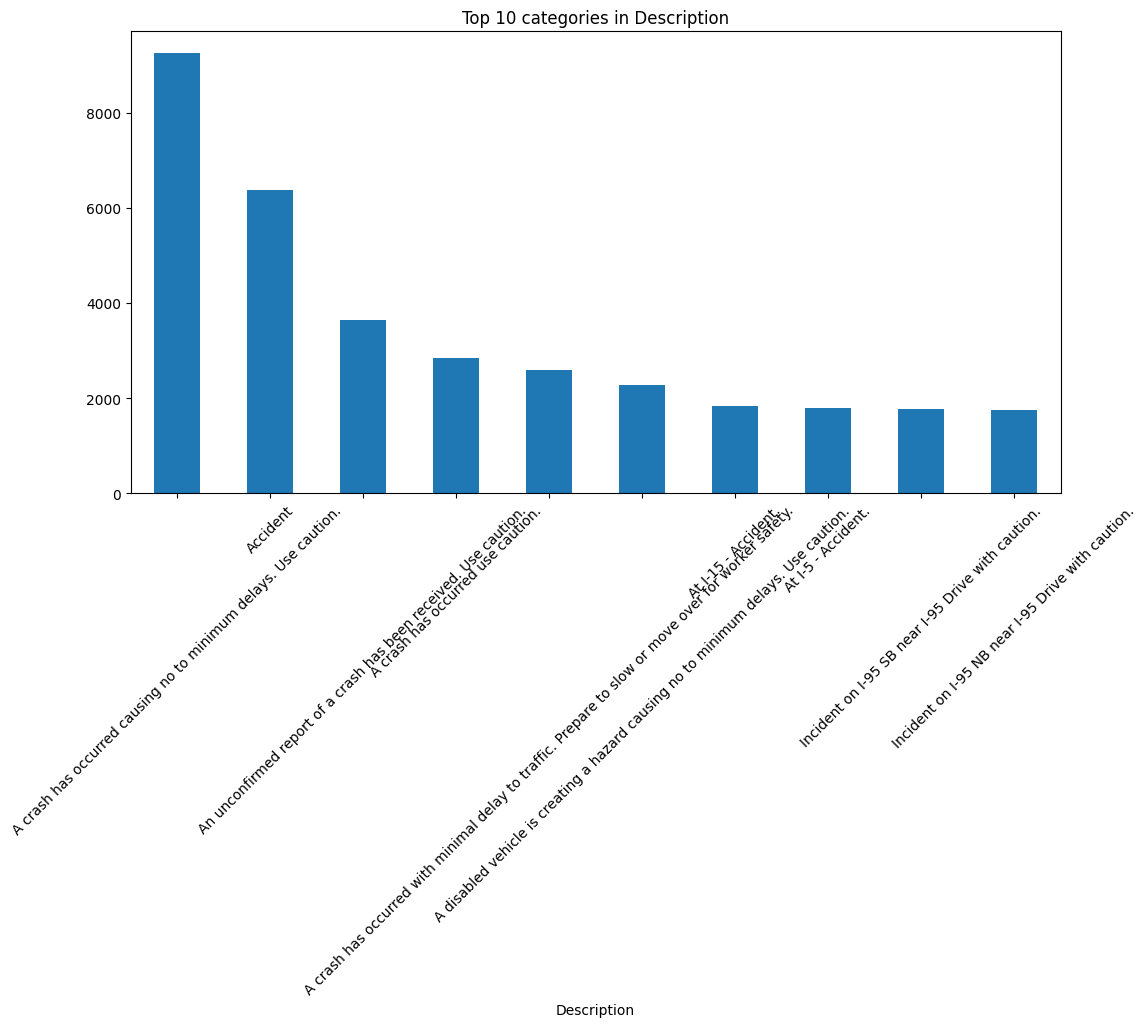

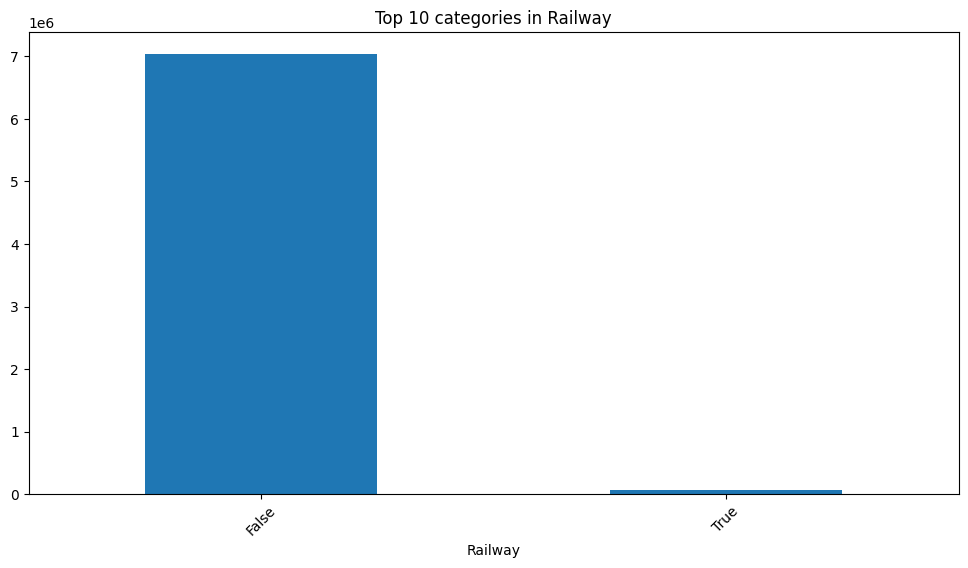


Class balance in full dataset:
Severity
2    0.804564
3    0.160621
4    0.025592
1    0.009224
Name: proportion, dtype: float64

Number of outliers in each numerical column:
Start_Lat: 0
Start_Lng: 0
Distance(mi): 101410
Temperature(F): 32265
Humidity(%): 0
Pressure(in): 224809
Visibility(mi): 216286
Wind_Speed(mph): 55824
Severity: 181586

Potential feature engineering ideas:
1. Create interaction terms between highly correlated features
2. Bin continuous variables
3. Create aggregate features (e.g., sum, mean, max of related features)
4. Extract time-based features if any datetime columns are present
5. Perform dimensionality reduction (e.g., PCA) on numerical features
6. Create dummy variables for categorical features with high cardinality


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the data
train_df = pd.read_csv('train_data_full.csv')
test_df = pd.read_csv('test_data_full.csv')

# Combine train and test for overall EDA
full_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

def perform_eda(df, title):
    print(f"\n{'-'*20} {title} {'-'*20}\n")
    
    # Basic information
    print(df.info())
    print("\nDataset shape:", df.shape)
    print("\nColumn names:", df.columns.tolist())
    
    # Summary statistics
    print("\nSummary statistics:")
    print(df.describe().T)
    
    # Missing values
    print("\nMissing values:")
    print(df.isnull().sum())
    
    # Unique values for each column
    print("\nUnique values for each column:")
    for col in df.columns:
        print(f"{col}: {df[col].nunique()}")
    
    # Distribution of target variable
    plt.figure(figsize=(10, 6))
    df['Severity'].value_counts().plot(kind='bar')
    plt.title('Distribution of Severity')
    plt.show()
    
    # Correlation matrix (only for numerical columns)
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    if len(numerical_columns) > 0:
        plt.figure(figsize=(12, 10))
        sns.heatmap(df[numerical_columns].corr(), annot=False, cmap='coolwarm', linewidths=0.5)
        plt.title('Correlation Matrix')
        plt.show()
    
    # Distribution plots for a sample of numerical columns
    sample_num_cols = np.random.choice(numerical_columns, min(5, len(numerical_columns)), replace=False)
    for col in sample_num_cols:
        plt.figure(figsize=(10, 6))
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.show()
    
    # Bar plots for a sample of categorical columns
    categorical_columns = df.select_dtypes(exclude=[np.number]).columns
    sample_cat_cols = np.random.choice(categorical_columns, min(5, len(categorical_columns)), replace=False)
    for col in sample_cat_cols:
        plt.figure(figsize=(12, 6))
        df[col].value_counts().nlargest(10).plot(kind='bar')
        plt.title(f'Top 10 categories in {col}')
        plt.xticks(rotation=45)
        plt.show()

# Perform EDA on full dataset
perform_eda(full_df, "Full Dataset EDA")

# Check for class imbalance
print("\nClass balance in full dataset:")
print(full_df['Severity'].value_counts(normalize=True))

# Check for outliers using Z-score (only for numerical columns)
def detect_outliers(df, columns, z_threshold=3):
    outliers = {}
    for col in columns:
        z_scores = np.abs(stats.zscore(df[col]))
        outliers[col] = (z_scores > z_threshold).sum()
    return outliers

numerical_columns = full_df.select_dtypes(include=[np.number]).columns
outliers = detect_outliers(full_df, numerical_columns)

print("\nNumber of outliers in each numerical column:")
for col, count in outliers.items():
    print(f"{col}: {count}")

# Feature engineering ideas
print("\nPotential feature engineering ideas:")
print("1. Create interaction terms between highly correlated features")
print("2. Bin continuous variables")
print("3. Create aggregate features (e.g., sum, mean, max of related features)")
print("4. Extract time-based features if any datetime columns are present")
print("5. Perform dimensionality reduction (e.g., PCA) on numerical features")
print("6. Create dummy variables for categorical features with high cardinality")


In [2]:
import pandas as pd

def print_column_info(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Print basic information about the dataset
    print(f"Dataset shape: {df.shape}")
    print(f"\nNumber of columns: {len(df.columns)}")
    
    # Print column names and their data types
    print("\nColumns and their data types:")
    for col in df.columns:
        print(f"- {col}: {df[col].dtype}")
    
    # Print some additional information about the columns
    print("\nAdditional column information:")
    for col in df.columns:
        print(f"\n{col}:")
        print(f"  - Number of unique values: {df[col].nunique()}")
        print(f"  - Number of null values: {df[col].isnull().sum()}")
        if df[col].dtype in ['int64', 'float64']:
            print(f"  - Min value: {df[col].min()}")
            print(f"  - Max value: {df[col].max()}")
        elif df[col].dtype == 'object':
            print(f"  - Most common value: {df[col].value_counts().index[0]}")

# List of your dataset files
files = ['train_data_full.csv', 'test_data_full.csv']

# Process each file
for file in files:
    print(f"\n{'='*50}")
    print(f"Processing file: {file}")
    print(f"{'='*50}")
    try:
        print_column_info(file)
    except FileNotFoundError:
        print(f"File not found: {file}")
    except Exception as e:
        print(f"An error occurred while processing {file}: {str(e)}")

print("\nColumn information output complete.")



Processing file: train_data_full.csv
Dataset shape: (5676439, 35)

Number of columns: 35

Columns and their data types:
- ID: object
- Source: object
- Start_Time: object
- End_Time: object
- Start_Lat: float64
- Start_Lng: float64
- Distance(mi): float64
- Description: object
- City: object
- County: object
- State: object
- Zipcode: object
- Country: object
- Weather_Timestamp: object
- Temperature(F): float64
- Humidity(%): float64
- Pressure(in): float64
- Visibility(mi): float64
- Wind_Direction: object
- Wind_Speed(mph): float64
- Weather_Condition: object
- Amenity: bool
- Bump: bool
- Crossing: bool
- Give_Way: bool
- Junction: bool
- No_Exit: bool
- Railway: bool
- Roundabout: bool
- Station: bool
- Stop: bool
- Traffic_Calming: bool
- Traffic_Signal: bool
- Turning_Loop: bool
- Severity: int64

Additional column information:

ID:
  - Number of unique values: 5676439
  - Number of null values: 0
  - Most common value: A-4712795

Source:
  - Number of unique values: 3
  - Numb

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

# Load the data
df = pd.read_csv('train_data_full.csv')  # Adjust filename if needed

# Convert timestamp columns to datetime
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['End_Time'] = pd.to_datetime(df['End_Time'])
df['Weather_Timestamp'] = pd.to_datetime(df['Weather_Timestamp'])

# Calculate accident duration
df['Duration'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 3600  # in hours

# 1. Accidents by State
plt.figure(figsize=(15, 6))
df['State'].value_counts().nlargest(15).plot(kind='bar')
plt.title('Top 15 States by Number of Accidents')
plt.xlabel('State')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

# 2. Accidents by Time of Day
df['Hour'] = df['Start_Time'].dt.hour
hourly_accidents = df['Hour'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
hourly_accidents.plot(kind='line', marker='o')
plt.title('Number of Accidents by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Number of Accidents')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Correlation between Temperature and Number of Accidents
temp_accidents = df.groupby('Temperature(F)').size().reset_index(name='Accidents')
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Temperature(F)', y='Accidents', data=temp_accidents)
plt.title('Relationship between Temperature and Number of Accidents')
plt.xlabel('Temperature (F)')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

# 4. Average Accident Duration by State
state_duration = df.groupby('State')['Duration'].mean().sort_values(ascending=False)
plt.figure(figsize=(15, 6))
state_duration.nlargest(15).plot(kind='bar')
plt.title('Average Accident Duration by State (Top 15)')
plt.xlabel('State')
plt.ylabel('Average Duration (hours)')
plt.tight_layout()
plt.show()

# 5. Accidents by Day of Week
df['Day_of_Week'] = df['Start_Time'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_accidents = df['Day_of_Week'].value_counts().reindex(day_order)
plt.figure(figsize=(10, 6))
weekly_accidents.plot(kind='bar')
plt.title('Number of Accidents by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

# 6. Severity Analysis
plt.figure(figsize=(8, 6))
df['Severity'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Accident Severity')
plt.xlabel('Severity Level')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

# 7. Correlation Heatmap
numeric_columns = ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Duration']
correlation_matrix = df[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

# Print some additional insights
print(f"Total number of accidents: {len(df)}")
print(f"Date range: from {df['Start_Time'].min()} to {df['Start_Time'].max()}")
print(f"Average accident duration: {df['Duration'].mean():.2f} hours")
print(f"Most common weather condition: {df['Weather_Condition'].mode()[0]}")
print("Top 5 cities with most accidents:")
print(df['City'].value_counts().nlargest(5))


ValueError: time data "2019-05-28 11:20:07" doesn't match format "%Y-%m-%d %H:%M:%S.%f", at position 2. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

Available columns:
['ID', 'Source', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Description', 'City', 'County', 'State', 'Zipcode', 'Country', 'Weather_Timestamp', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Severity']


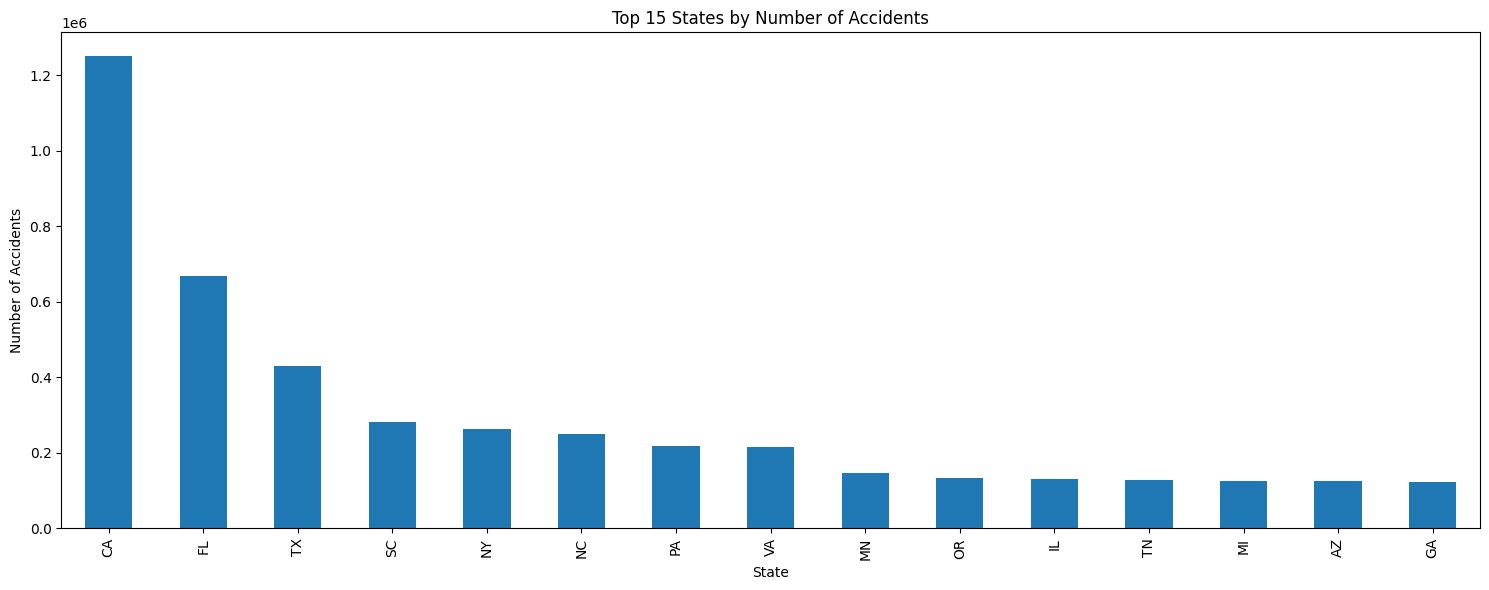

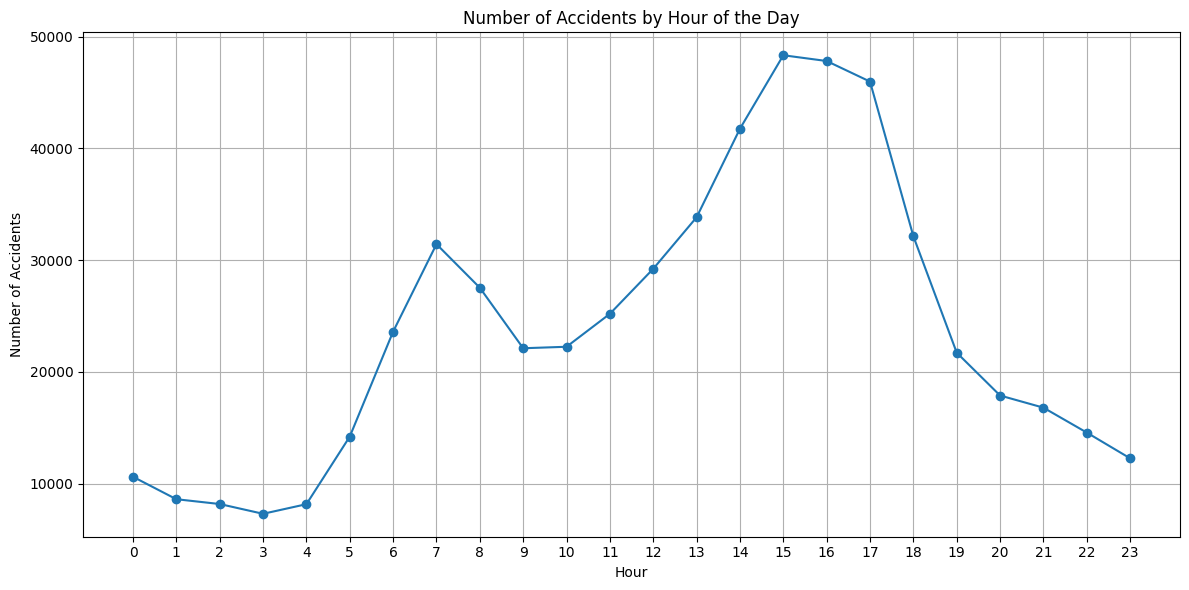

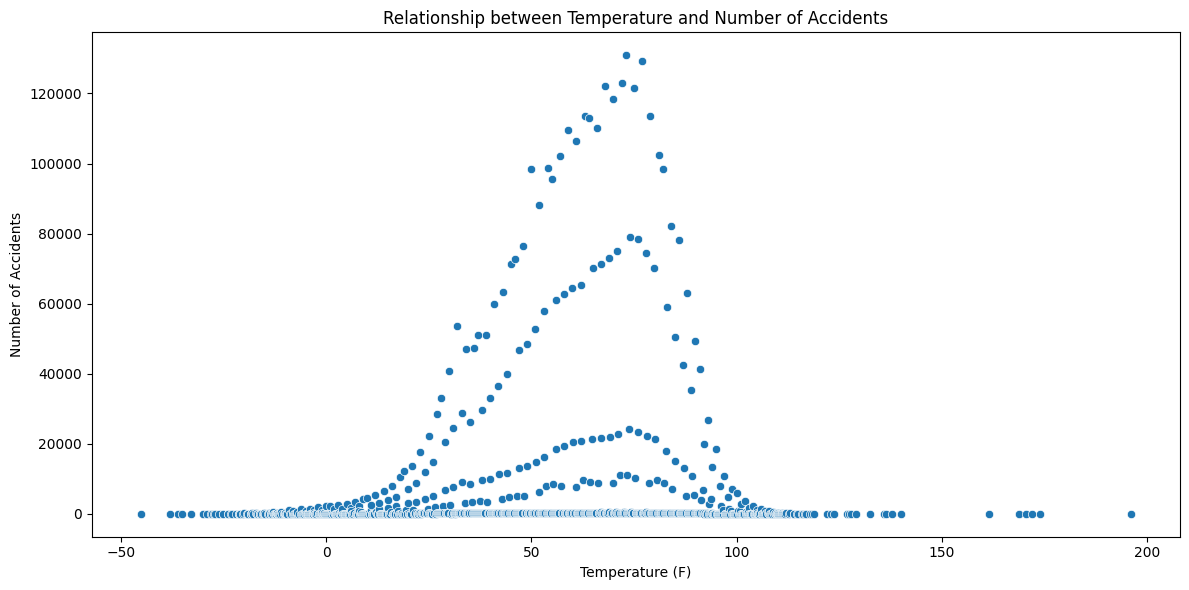

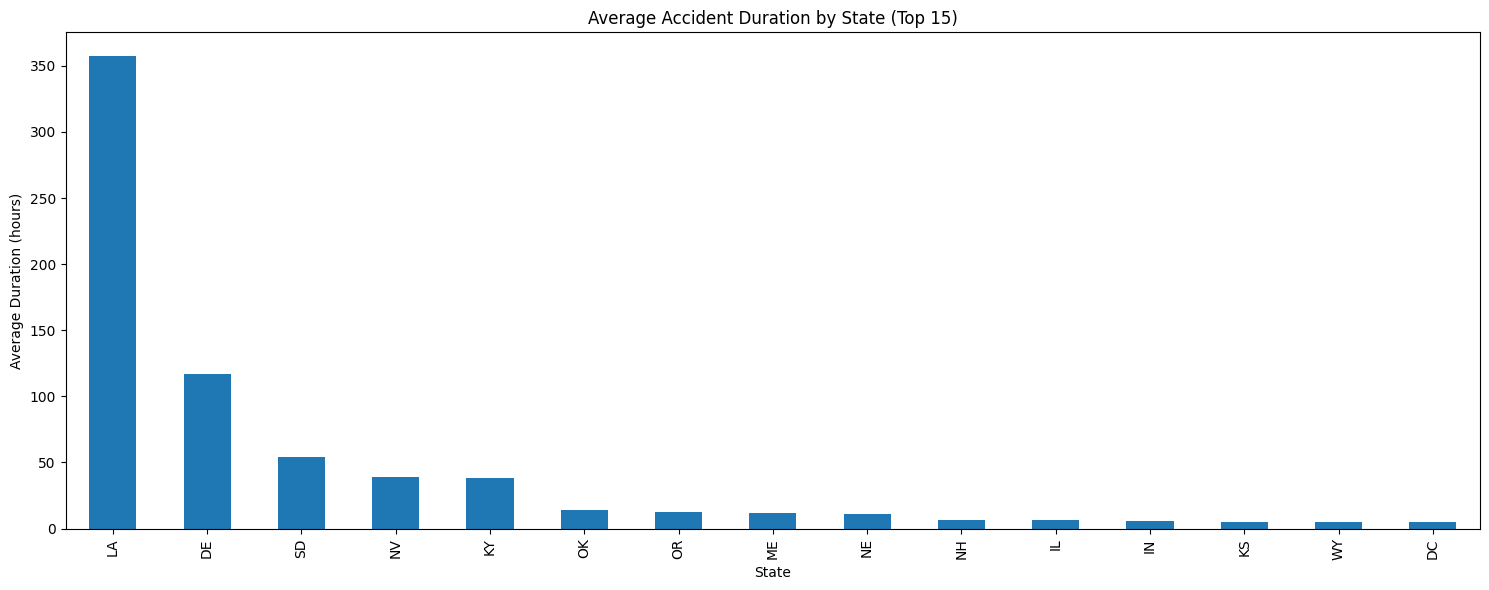

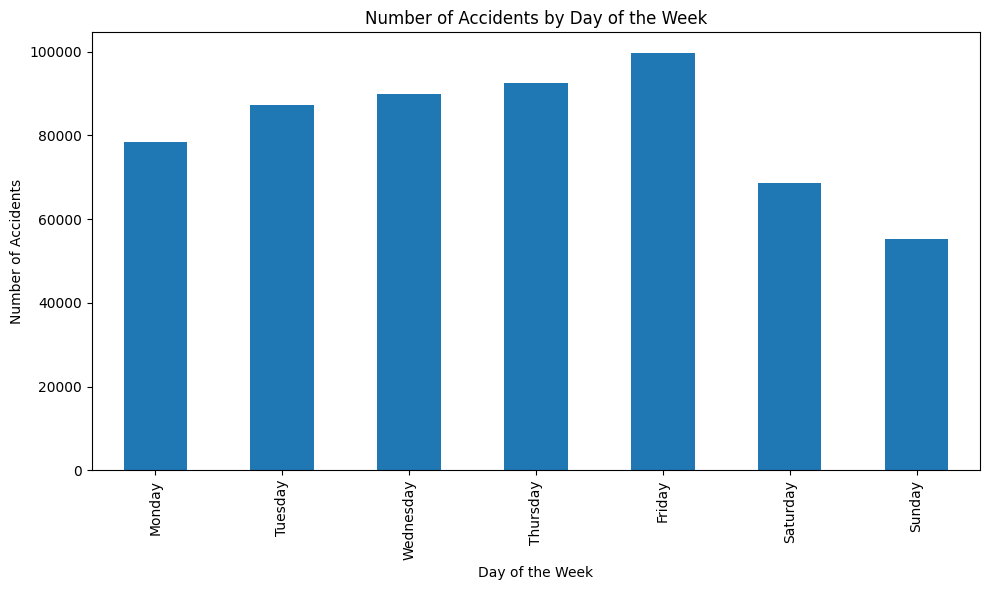

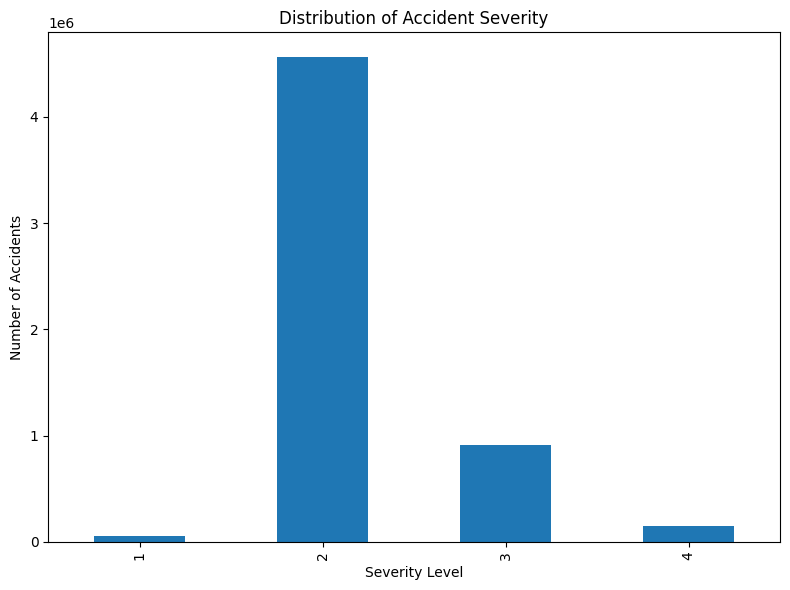

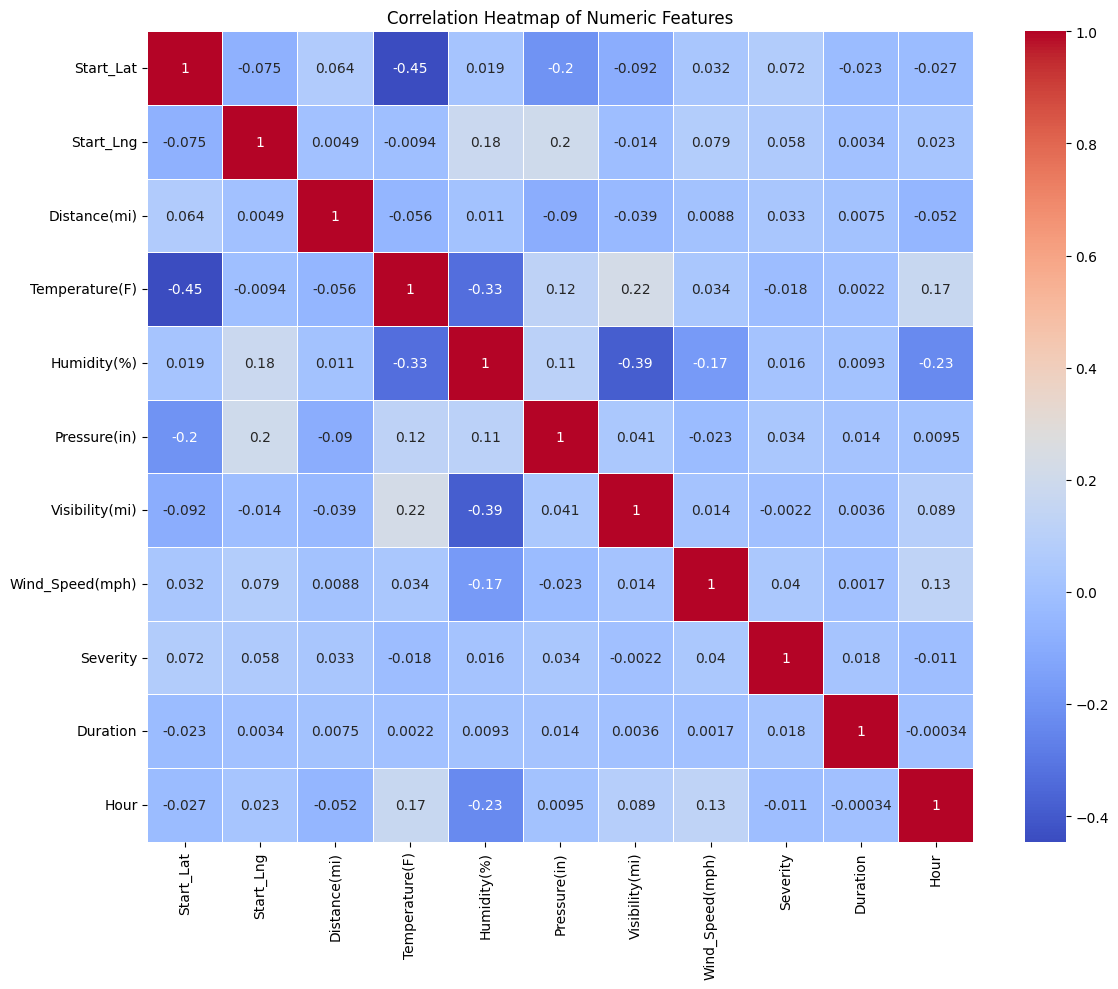


Total number of accidents: 5676439
Date range: from 2017-07-23 05:18:46 to 2023-03-31 23:17:00
Average accident duration: 10.20 hours
Most common weather condition: Fair
Top 5 cities with most accidents:
City
Miami          145242
Houston        124552
Los Angeles    105720
Charlotte      102699
Dallas         101659
Name: count, dtype: int64


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

# Load the data
df = pd.read_csv('train_data_full.csv')  # Adjust filename if needed

# Print column names to inspect available columns
print("Available columns:")
print(df.columns.tolist())

# Convert timestamp columns to datetime using a more flexible approach
for col in ['Start_Time', 'End_Time', 'Weather_Timestamp']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Calculate accident duration
df['Duration'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 3600  # in hours

# 1. Accidents by State
plt.figure(figsize=(15, 6))
df['State'].value_counts().nlargest(15).plot(kind='bar')
plt.title('Top 15 States by Number of Accidents')
plt.xlabel('State')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

# 2. Accidents by Time of Day
df['Hour'] = df['Start_Time'].dt.hour
hourly_accidents = df['Hour'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
hourly_accidents.plot(kind='line', marker='o')
plt.title('Number of Accidents by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Number of Accidents')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Correlation between Temperature and Number of Accidents
temp_accidents = df.groupby('Temperature(F)').size().reset_index(name='Accidents')
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Temperature(F)', y='Accidents', data=temp_accidents)
plt.title('Relationship between Temperature and Number of Accidents')
plt.xlabel('Temperature (F)')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

# 4. Average Accident Duration by State
state_duration = df.groupby('State')['Duration'].mean().sort_values(ascending=False)
plt.figure(figsize=(15, 6))
state_duration.nlargest(15).plot(kind='bar')
plt.title('Average Accident Duration by State (Top 15)')
plt.xlabel('State')
plt.ylabel('Average Duration (hours)')
plt.tight_layout()
plt.show()

# 5. Accidents by Day of Week
df['Day_of_Week'] = df['Start_Time'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_accidents = df['Day_of_Week'].value_counts().reindex(day_order)
plt.figure(figsize=(10, 6))
weekly_accidents.plot(kind='bar')
plt.title('Number of Accidents by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

# 6. Severity Analysis
plt.figure(figsize=(8, 6))
df['Severity'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Accident Severity')
plt.xlabel('Severity Level')
plt.ylabel('Number of Accidents')
plt.tight_layout()
plt.show()

# 7. Correlation Heatmap
# We'll use only the numeric columns that are actually in the dataset
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

# Print some additional insights
print(f"\nTotal number of accidents: {len(df)}")
print(f"Date range: from {df['Start_Time'].min()} to {df['Start_Time'].max()}")
print(f"Average accident duration: {df['Duration'].mean():.2f} hours")
print(f"Most common weather condition: {df['Weather_Condition'].mode()[0]}")
print("Top 5 cities with most accidents:")
print(df['City'].value_counts().nlargest(5))


In [7]:
# Load the data
# Adjust the file name if necessary
df = pd.read_excel('census_data.xlsx')

# Clean up column names
df.columns = df.columns.str.strip()

# Extract population columns
population_columns = ['April 1, 2020 Estimates Base'] + [f'Population Estimate (as of July 1){year}' for year in range(2020, 2024)]

# Melt the dataframe to long format for easier analysis
df_melted = df.melt(id_vars=['Geographic Area'], 
                    value_vars=population_columns, 
                    var_name='Year', 
                    value_name='Population')

# Clean up the Year column
df_melted['Year'] = df_melted['Year'].replace({
    'April 1, 2020 Estimates Base': '2020 Base',
    'Population Estimate (as of July 1)2020': '2020',
    'Population Estimate (as of July 1)2021': '2021',
    'Population Estimate (as of July 1)2022': '2022',
    'Population Estimate (as of July 1)2023': '2023'
})

# Convert Population to numeric, removing any non-numeric characters
df_melted['Population'] = pd.to_numeric(df_melted['Population'].replace('[^0-9.]', '', regex=True), errors='coerce')

# Basic statistics
print("Basic Statistics:")
print(df_melted.groupby('Year')['Population'].describe())

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['Geographic Area', 'April 1, 2020 Estimates Base', 'Population Estimate (as of July 1)2020', 'Population Estimate (as of July 1)2021', 'Population Estimate (as of July 1)2022', 'Population Estimate (as of July 1)2023']"

In [23]:
# Load the data, skipping the first two rows which contain metadata
census_df = pd.read_excel('census_data.xlsx', skiprows=2, header=[0, 1])

census_df.head()

census_df.columns

MultiIndex([(                   'Geographic Area', 'Unnamed: 0_level_1'),
            (     'April 1, 2020\nEstimates Base', 'Unnamed: 1_level_1'),
            ('Population Estimate (as of July 1)',                 2020),
            ('Population Estimate (as of July 1)',                 2021),
            ('Population Estimate (as of July 1)',                 2022),
            ('Population Estimate (as of July 1)',                 2023)],
           )

In [24]:
# Assuming your DataFrame is named census_df
# Flatten the multi-index columns
census_df.columns = [f'{col[0]}_{col[1]}' if col[1] != '' else col[0] for col in census_df.columns]

# Rename columns to make them more user-friendly
census_df = census_df.rename(columns={
    'Geographic Area': 'City',
    'April 1, 2020\nEstimates Base_Unnamed: 1_level_1': 'Estimate_Base_2020',
    'Population Estimate (as of July 1)_2020': 'Population_2020',
    'Population Estimate (as of July 1)_2021': 'Population_2021',
    'Population Estimate (as of July 1)_2022': 'Population_2022',
    'Population Estimate (as of July 1)_2023': 'Population_2023'
})

# Display the new column names
print(census_df.columns)

# Display the first few rows of the simplified DataFrame
print(census_df.head())

Index(['Geographic Area_Unnamed: 0_level_1', 'Estimate_Base_2020',
       'Population_2020', 'Population_2021', 'Population_2022',
       'Population_2023'],
      dtype='object')
  Geographic Area_Unnamed: 0_level_1  Estimate_Base_2020  Population_2020  \
0            Abbeville city, Alabama              2350.0           2351.0   
1           Adamsville city, Alabama              4372.0           4360.0   
2              Addison town, Alabama               662.0            660.0   
3                Akron town, Alabama               229.0            229.0   
4            Alabaster city, Alabama             33334.0          33392.0   

   Population_2021  Population_2022  Population_2023  
0           2357.0           2364.0           2377.0  
1           4292.0           4222.0           4172.0  
2            666.0            670.0            667.0  
3            228.0            223.0            224.0  
4          33748.0          33869.0          34107.0  


In [27]:
census_df.head()

,Geographic Area_Unnamed: 0_level_1,Estimate_Base_2020,Population_2020,Population_2021,Population_2022,Population_2023
0,"Abbeville city, Alabama",2350.0,2351.0,2357.0,2364.0,2377.0
1,"Adamsville city, Alabama",4372.0,4360.0,4292.0,4222.0,4172.0
2,"Addison town, Alabama",662.0,660.0,666.0,670.0,667.0
3,"Akron town, Alabama",229.0,229.0,228.0,223.0,224.0
4,"Alabaster city, Alabama",33334.0,33392.0,33748.0,33869.0,34107.0


In [31]:
# Split the 'Geographic Area_Unnamed: 0_level_1' column into 'City' and 'State'
# Use 'n=1' to ensure only one split (in case there are commas in city names)
split_data = census_df['Geographic Area_Unnamed: 0_level_1'].str.split(', ', expand=True, n=1)

# Assign the split results to 'City' and 'State'
census_df['City'] = split_data[0]
census_df['State'] = split_data[1]

# Drop the original 'Geographic Area_Unnamed: 0_level_1' column if no longer needed
census_df.drop(columns=['Geographic Area_Unnamed: 0_level_1'], inplace=True)

# Display the first few rows of the updated DataFrame
print(census_df.head())

   Estimate_Base_2020  Population_2020  Population_2021  Population_2022  \
0              2350.0           2351.0           2357.0           2364.0   
1              4372.0           4360.0           4292.0           4222.0   
2               662.0            660.0            666.0            670.0   
3               229.0            229.0            228.0            223.0   
4             33334.0          33392.0          33748.0          33869.0   

   Population_2023             City    State  
0           2377.0   Abbeville city  Alabama  
1           4172.0  Adamsville city  Alabama  
2            667.0     Addison town  Alabama  
3            224.0       Akron town  Alabama  
4          34107.0   Alabaster city  Alabama  


FileNotFoundError: [Errno 2] No such file or directory: '/content/sample_data/test_data_numerical.csv'